<a href="https://colab.research.google.com/github/unjuken/DeepQ-RubiksCube/blob/main/Aprendizaje_Profundo_202110_Taller_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

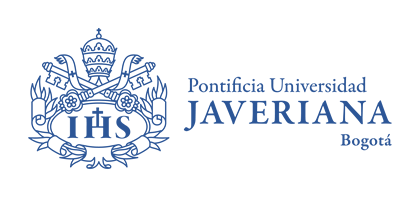

# Aprendizaje profundo - Taller 2
Este notebook tiene como objetivo familiarizar al estudiante con un ambiente de aprendizaje por refuerzo bajo el API de OpenAI Gym



En el segundo taller del curso se utilizará el framework OpenAI Gym y Tensorflow Agents para crear una red neuronal profunda que resuelva un cubo de rubik de 2x2x2 utilizando el gimnasio RubiksCubeGym disponible [en github siguiendo este link](https://github.com/DoubleGremlin181/RubiksCubeGym)



Este notebook utiliza instrucciones del tutorial **Train a Deep Q Network with TF-Agents** disponible en este [link](https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=pmDI-h7cI0tI)  


## Setup
Se instalan y se importan las librerías necesarias para el ejercicio

In [1]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install rubiks-cube-gym

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,411 kB]
Hit:12 http://ppa.launchpad.net

In [2]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [3]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Exploración del ambiente

En las siguientes celdas se explora el ambiente rubiks cube, cómo se visualiza el cubo y las acciones que se pueden aplicar al cubo

In [4]:
env_name='rubiks-cube-222-v0'

In [5]:
import rubiks_cube_gym

In [6]:
env = suite_gym.load(env_name)
env.reset()

State file not found
Downloading...
Download complete


TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array(1560298))

Una vez cargado el gimnasio, se puede visualizar el estado del cubo, el cubo inicia con un estado aleatorio

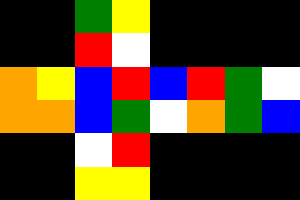

In [7]:
# Visualización como imagen del entorno
PIL.Image.fromarray(env.render()).resize((300,200),PIL.Image.BOX)

In [8]:
# Visualización del entorno como string de resumen
env.cube_reduced 

'GYRWOYBRBRGWOOBGWOGBWRYY'

In [9]:
# Visualización del entorno como arreglo RGB
env.render()

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0, 128,   0],
        [255, 255,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [255,   0,   0],
        [255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 165,   0],
        [255, 255,   0],
        [  0,   0, 255],
        [255,   0,   0],
        [  0,   0, 255],
        [255,   0,   0],
        [  0, 128,   0],
        [255, 255, 255]],

       [[255, 165,   0],
        [255, 165,   0],
        [  0,   0, 255],
        [  0, 128,   0],
        [255, 255, 255],
        [255, 165,   0],
        [  0, 128,   0],
        [  0,   0, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [255, 255, 255],
        [255,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0

El cubo se puede inicializar en alguna configuración por defecto también utilizando la notación [WCA disponible en este link](https://www.worldcubeassociation.org/regulations/#article-12-notation)

El método de reset con parámetros no esta disponible en el api de tf_agents, por lo que se inicializa el ambiente en este caso utilizando gym

In [10]:
import gym
env_gym = gym.make(env_name)  
env_gym.reset(scramble="R U R' U' R' F R2 U' R' U' R U R' F'") 
env_gym.cube_reduced


'WWWWOOGRBGRBOOGGRRBBYYYY'

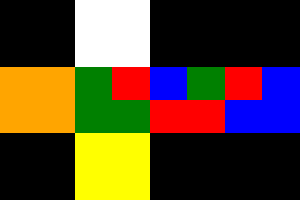

In [11]:
PIL.Image.fromarray(env_gym.render(mode='rgb_array')).resize((300,200),PIL.Image.BOX)

In [12]:
# Ambiente con cubo ordenado
import gym
env_gym_ordered = gym.make(env_name)  
env_gym_ordered.reset(scramble="R R'") 
env_gym_ordered.cube_reduced

'WWWWOOGGRRBBOOGGRRBBYYYY'

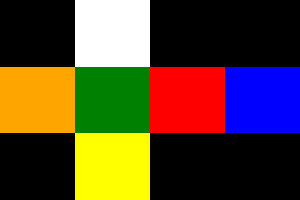

In [13]:
PIL.Image.fromarray(env_gym_ordered.render(mode='rgb_array')).resize((300,200),PIL.Image.BOX)

## Acciones, espacio de observación y recompensas en tf-agents

El método `time_step_spec()`retorna la especificación del ambiente para avanzar un paso en el tiempo el ambiente.

`observation` indica las posibles combinaciones del cubo que existen: 3674160



In [14]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='observation', minimum=0, maximum=3674159)


`reward` indica la configuración de la recompensa, en este caso es un float

In [15]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


El método `action_spec()` retorna las acciones válidas sobre el ambiente. En este caso se tienen 3 acciones que rotar 90 grados en sentido de las agujas del reloj la siguiente superficie del cubo:

*   0 indica girar la cara frontal del cubo
*   1 indica girar la cara derecha del cubo
*   2 indica girar la cara superior del cubo



In [16]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)


Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array(811719))


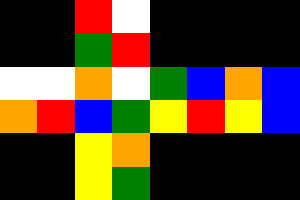

In [17]:
time_step = env.reset()
print('Time step:')
print(time_step)
PIL.Image.fromarray(env.render()).resize((300,200),PIL.Image.BOX)


In [18]:
env.cube_reduced


'RWGRWWOWGBOBORBGYRYBYOYG'

In [19]:
action = np.array(1, dtype=np.int32)
next_time_step = env.step(action)

print('Next time step:')
print(next_time_step)

Next time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(-1., dtype=float32), discount=array(1., dtype=float32), observation=array(811720))


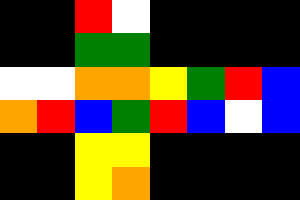

In [20]:
PIL.Image.fromarray(env.render()).resize((300,200),PIL.Image.BOX)

In [21]:
env.cube_reduced

'RWGGWWOOYGRBORBGRBWBYYYO'

Note que la recomensa para los pasos dados con las acciones es -1, esto se debe a que el ambiente por defecto retorna -1 a menos que el cubo este completamente ordenado. Revise el siguiente [link](https://github.com/DoubleGremlin181/RubiksCubeGym/blob/master/rubiks_cube_gym/envs/rubiks_cube_222.py#L105) en la función `reward(self,action)` del ambiente.

 

## Extendiendo el ambiente por defecto para incluir una función de recompensa propia

Para extender el ambiente por defecto se debe extender la clase  `RubiksCube222Env` y reimplementar el método `reward(self,action)` 



In [22]:
from rubiks_cube_gym.envs.rubiks_cube_222 import  RubiksCube222Env

Se crea una clase nueva que retorna una recompensa proporcional al número de casillas correctas en el cubo.

In [23]:
class NaiveRubiksCube222(RubiksCube222Env):
  solved="WWWWOOGGRRBBOOGGRRBBYYYY"
  def __init__(self):
        super(NaiveRubiksCube222, self).__init__()

  def reward(self):
    
    if self.cube_reduced == self.solved:
      return 100,True
    reward=0  
    for i in range(0,len(self.cube_reduced)):
      reward+=self.solved[i]==self.cube_reduced[i]
    return reward, False

from gym.envs.registration import register

register(
    id='naive-rubiks-cube-222-v0',
    entry_point='__main__:NaiveRubiksCube222',
    max_episode_steps=250,
)


In [24]:
env_naive = suite_gym.load('naive-rubiks-cube-222-v0')

Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array(2148812))


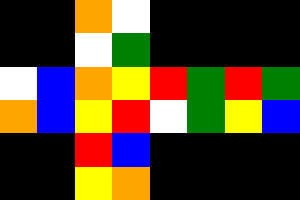

In [25]:
time_step = env_naive.reset()
print('Time step:')
print(time_step)
PIL.Image.fromarray(env_naive.render()).resize((300,200),PIL.Image.BOX)

In [26]:
action = np.array(1, dtype=np.int32)
next_time_step = env_naive.step(action)

print('Next time step:')
print(next_time_step)

Next time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(6., dtype=float32), discount=array(1., dtype=float32), observation=array(2328379))


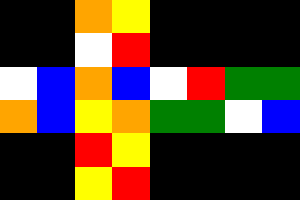

In [27]:
PIL.Image.fromarray(env_naive.render()).resize((300,200),PIL.Image.BOX)

## Entrenamiento y ajuste de redes neuronales profundas con el agente

Para continuar con el taller, revise el notebook **Train a Deep Q Network with TF-Agents** disponible en este [link](https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=pmDI-h7cI0tI). Allí se muestra como crear un agente de TensorFlow a partir de un gimnasio de OpenAI gym, el entrenamiento y test de una red Deep Q Network. 

Se asignan los parámetros

In [28]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}


Funciones de ayuda para facilitar el entrenamiento y la experimentación:

In [42]:
from  tf_agents.networks  import  q_network 
import numpy as np

def createEnvironments(env_name):
  train_py_env = suite_gym.load(env_name)
  eval_py_env = suite_gym.load(env_name)
  train_env = tf_py_environment.TFPyEnvironment(train_py_env)
  eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)
  return train_py_env, eval_py_env, train_env, eval_env

def createQNet(train_env, fc_layer_params = (100 ,100), activation_fn = tf.keras.activations.relu,  dropout_layer_params = None):
  q_net = q_network.QNetwork( train_env.observation_spec(), train_env.action_spec(), fc_layer_params=fc_layer_params, activation_fn = activation_fn, dropout_layer_params = dropout_layer_params) 
  return q_net

def create_and_init_agent(train_env, q_net, optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)):
  train_step_counter = tf.Variable(0)
  agent = dqn_agent.DqnAgent(
      train_env.time_step_spec(),
      train_env.action_spec(),
      q_network=q_net,
      optimizer=optimizer,
      td_errors_loss_fn=common.element_wise_squared_loss)
  agent.initialize()
  return agent

#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

#@test {"skip": true}
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see tutorial 4 or the drivers module.
# https://github.com/tensorflow/agents/blob/master/docs/tutorials/4_drivers_tutorial.ipynb 
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers


def prepare_environment_for_training(env_name = 'rubiks-cube-222-v0', fc_layer_params = (100 ,100), activation_fn = tf.keras.activations.relu,  dropout_layer_params = None, optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)):
  train_py_env, eval_py_env, train_env, eval_env = createEnvironments(env_name)
  q_net = createQNet(train_env, fc_layer_params, activation_fn, dropout_layer_params)
  agent = create_and_init_agent(train_env, q_net, optimizer)
  q_net.summary()
  eval_policy = agent.policy
  collect_policy = agent.collect_policy
  random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(data_spec=agent.collect_data_spec, batch_size=train_env.batch_size, max_length=replay_buffer_max_length)
  collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)
  # Dataset generates trajectories with shape [Bx2x...]
  dataset = replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)
  iterator = iter(dataset)
  return train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator

def train_environment(agent, train_env, eval_env, replay_buffer, iterator, num_iterations, num_eval_episodes, collect_steps_per_iteration,  eval_interval):
  try:
    %%time
  except:
    pass

  # (Optional) Optimize by wrapping some of the code in a graph using TF function.
  agent.train = common.function(agent.train)
  # Reset the train step
  agent.train_step_counter.assign(0)
  # Evaluate the agent's policy once before training.
  avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
  returns = [avg_return]
  for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)
    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()
    if step % log_interval == 0:
      print('step = {0}: loss = {1}'.format(step, train_loss))
    if step % eval_interval == 0:
      avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
      print('step = {0}: Average Return = {1}'.format(step, avg_return))
      returns.append(avg_return)
  return returns

def plot_training(num_iterations, eval_interval, returns):
  iterations = range(0, num_iterations + 1, eval_interval)
  plt.plot(iterations, returns)
  plt.ylabel('Average Return')
  plt.xlabel('Iterations') 

def train_environment_and_plot(agent, train_env, eval_env, replay_buffer, iterator, num_iterations, num_eval_episodes, collect_steps_per_iteration, eval_interval):
  returns = train_environment(agent, train_env, eval_env, replay_buffer, iterator, num_iterations, num_eval_episodes, collect_steps_per_iteration,  eval_interval)
  plot_training(num_iterations, eval_interval, returns)
  return returns

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=2):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      im = PIL.Image.fromarray(eval_py_env.render()).resize((300,200),PIL.Image.BOX)
      video.append_data(np.array(im))
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        im = PIL.Image.fromarray(eval_py_env.render()).resize((300,200),PIL.Image.BOX)
        video.append_data(np.array(im))
  return embed_mp4(filename)


Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  10300     
_________________________________________________________________
dense_26 (Dense)             multiple                  303       
Total params: 10,603
Trainable params: 10,603
Non-trainable params: 0
_________________________________________________________________
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 68.4 µs
step = 200: loss = 48642672.0
step = 400: loss = 92400856.0
step = 600: loss = 2906971648.0
step = 800: loss = 74121664.0
step = 1000: loss = 189919296.0
step = 1000: Average Return = -250.0
step = 1200: loss = 1377.901123046875
step = 1400: loss = 7.592963218688965
step = 1600: loss = 3.6218180656433105
step = 1800: loss = 4.934714317321777
step = 2000: loss = 2.0492985248565674
step = 2000: Average Return = -250.0
step = 2200: loss = 1.5884943008

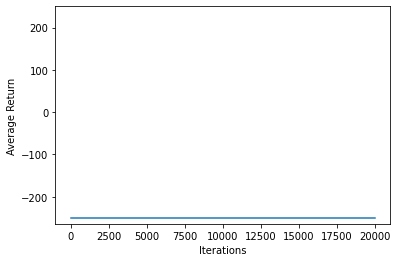

In [38]:
env_name = "rubiks-cube-222-v0" #@param {type:"string"}
fc_layer_params = (100 ,100) #@param {type:"raw"}
activation_fn = tf.keras.activations.relu #@param ["tf.keras.activations.relu", "tf.keras.activations.selu", "tf.keras.activations.softmax", "tf.keras.activations.tanh"] {type:"raw"}
dropout_layer_params = None # @param {type:"raw"}
optimizer_type = tf.keras.optimizers.Adam # @param {type:"raw"}

num_iterations = 20000 # @param {type:"integer"} 

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

optimizer = optimizer_type(learning_rate=learning_rate)



#Configurar, entrenar, y mostrar gráfica
train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator = prepare_environment_for_training(env_name, fc_layer_params, activation_fn,  dropout_layer_params, optimizer)
returns = train_environment(agent, train_env, eval_env, replay_buffer, iterator, num_iterations, num_eval_episodes, collect_steps_per_iteration, eval_interval)
plot_training(num_iterations, eval_interval, returns)

In [40]:

create_policy_eval_video(agent.policy, "trained-agent")


Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  10300     
_________________________________________________________________
dense_32 (Dense)             multiple                  303       
Total params: 10,603
Trainable params: 10,603
Non-trainable params: 0
_________________________________________________________________
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs
step = 200: loss = 98476.46875
step = 400: loss = 2137.135986328125
step = 600: loss = 1916.3363037109375
step = 800: loss = 31026.86328125
step = 1000: loss = 6164.3818359375
step = 1000: Average Return = 1719.0
step = 1200: loss = 44554.046875
step = 1400: loss = 3715.470703125
step = 1600: loss = 101480.375
step = 1800: loss = 2570256.25
step = 2000: loss = 73507872.0
step = 2000: Average Return = 1468.300048828125
step = 2200: loss = 387517

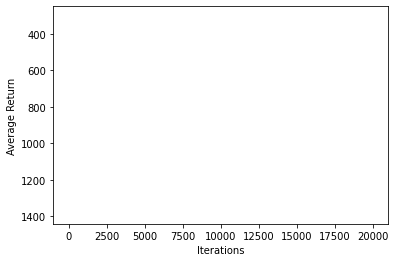

In [41]:
env_name = "naive-rubiks-cube-222-v0" #@param {type:"string"}
fc_layer_params = (100 ,100) #@param {type:"raw"}
activation_fn = tf.keras.activations.relu #@param ["tf.keras.activations.relu", "tf.keras.activations.selu", "tf.keras.activations.softmax", "tf.keras.activations.tanh"] {type:"raw"}
dropout_layer_params = None # @param {type:"raw"}
optimizer_type = tf.keras.optimizers.Adam # @param {type:"raw"}

num_iterations = 20000 # @param {type:"integer"} 

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

optimizer = optimizer_type(learning_rate=learning_rate)



#Configurar, entrenar, y mostrar gráfica
train_py_env, eval_py_env, train_env, eval_env, q_net, agent, replay_buffer, dataset, iterator = prepare_environment_for_training(env_name, fc_layer_params, activation_fn,  dropout_layer_params, optimizer)
returns = train_environment(agent, train_env, eval_env, replay_buffer, iterator, num_iterations, num_eval_episodes, collect_steps_per_iteration, eval_interval)
plot_training(num_iterations, eval_interval, returns)

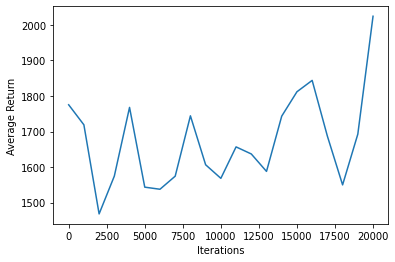

In [43]:
plot_training(num_iterations, eval_interval, returns)

In [44]:
create_policy_eval_video(agent.policy, "trained-agent")